In [24]:
#!pip install pytrends
from google.cloud import bigquery
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, datetime, timedelta
from pytrends.request import TrendReq
import time
import pandas as pd
import matplotlib
import gtrend
from scipy import stats
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold


plt.style.use('seaborn-darkgrid')
matplotlib.rcParams['font.family'] = ['Heiti TC']
def rmax(maxrow: int=50):
    pd.set_option('display.max_rows', maxrow)

def cmax(maxcol: int=50):
    pd.set_option('display.max_columns', maxcol)

In [25]:
interpolate_mode ='M'
if interpolate_mode =='M':
    lag_shift = 2
    covid_period = 4
elif interpolate_mode =='W':
    lag_shift = 9
    covid_period = 20
else:
    lag_shift = 60
    covid_period = 120


In [26]:
pytrend = TrendReq(hl='en-US')
keyword = 'tenue de mariage'
start = '2016-01-01'
end = '2020-05-31'
geo='FR'
cat=0
gprop=''

In [27]:
start_d = datetime.strptime(start, '%Y-%m-%d')
end_d = datetime.strptime(end, '%Y-%m-%d')
s_year = start_d.year
s_mon = start_d.month
e_year = end_d.year
e_mon = end_d.month



In [28]:
tf = start_d.strftime('%Y-%m-%d')+' '+end_d.strftime('%Y-%m-%d')
pytrend.build_payload(kw_list=[keyword], cat=cat, geo=geo, gprop=gprop, timeframe=tf)
week = pytrend.interest_over_time()
#print(len(week),'\n')
#print(week.head(),'\n')


#week_interp = week

week_interp = week.resample(interpolate_mode).mean() # agrège par jour 'D' et ordonne (mean pour moyenne en méthode d'agrégat)

#print(len(week_interp),'\n')
#print(week_interp.head(),'\n')
trend_column = f'{keyword}_trend'
week_interp[trend_column] = week_interp[f'{keyword}'].interpolate() # interpolation sur les jours

#print(len(week_interp),'\n')
#print(week_interp.head(),'\n')

In [29]:
week_interp.drop(columns='isPartial', inplace=True)
week_interp.drop(columns=f'{keyword}', inplace=True)

tenue de mariage_trend
date                              
2016-01-31                   31.60
2016-02-29                   42.50
2016-03-31                   46.75
2016-04-30                   59.25
2016-05-31                   49.60


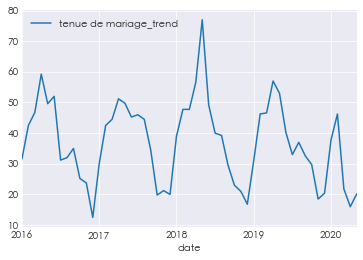

In [30]:

week_interp.plot()
print(week_interp.head())

In [31]:

global_param = {
    'default_gcp_project_id' : 'fd-io-dlk-jules',
    'default_bq_dataset' : 'tmp',
    'input_table_name' : 'ventes_costumes_date_1'
}

client = bigquery.Client(project = global_param['default_gcp_project_id'])

def gbq_table_to_dataframe(table = global_param['input_table_name'], project_id = global_param['default_gcp_project_id'], dataset = global_param['default_bq_dataset']):
    """
    function for import table from Bigquery to Dataframe Pandas
    """
    t0 = time.time()
    dataset_ref = client.dataset(dataset, project=project_id)
    
    table_ref = dataset_ref.table(table)    
    table = client.get_table(table_ref)
    df = client.list_rows(table).to_dataframe()

    t_batch = time.time() - t0
    print("####  computation time : " + str(t_batch) + "s  ####")

    return df
    
df_sales = gbq_table_to_dataframe()


#### convert object type to int/datetime AND set index to sale_date
df_sales['sale_date'] = pd.to_datetime(df_sales['sale_date'])
df_sales['CA'] = pd.to_numeric(df_sales['CA'])

df_sales = df_sales.set_index('sale_date')


#### order by day and interpolate to have the same values as the trends
df_sales = df_sales.resample(interpolate_mode).sum() # agrège par jour 'D' et ordonne
#df_sales['CA'] = df_sales['CA'].interpolate() # interpolation sur les jours
#df_sales['nb_sales'] = df_sales['nb_sales'].interpolate() # interpolation sur les jours



print(df_sales.head())
print(df_sales.shape)

####  computation time : 0.49831390380859375s  ####
            nb_sales          CA
sale_date                       
2016-01-31     39887  1103140.24
2016-02-29     44500  1317303.84
2016-03-31     56164  1857875.62
2016-04-30     77787  2582234.26
2016-05-31     96273  3127452.19
(54, 2)


In [32]:
frames = [df_sales, week_interp]
df = pd.concat(frames, axis=1, join='inner')
print(df.head())
df.shape

nb_sales          CA  tenue de mariage_trend
sale_date                                               
2016-01-31     39887  1103140.24                   31.60
2016-02-29     44500  1317303.84                   42.50
2016-03-31     56164  1857875.62                   46.75
2016-04-30     77787  2582234.26                   59.25
2016-05-31     96273  3127452.19                   49.60


(53, 3)

In [33]:
def decompose_time_series(series):
    """
    Decompose a time series and plot it in the console
    Arguments: 
        series: series. Time series that we want to decompose
    Outputs: 
        Decomposition plot in the console
    """
    result = seasonal_decompose(series, model='additive')
    result.plot()
    plt.show()

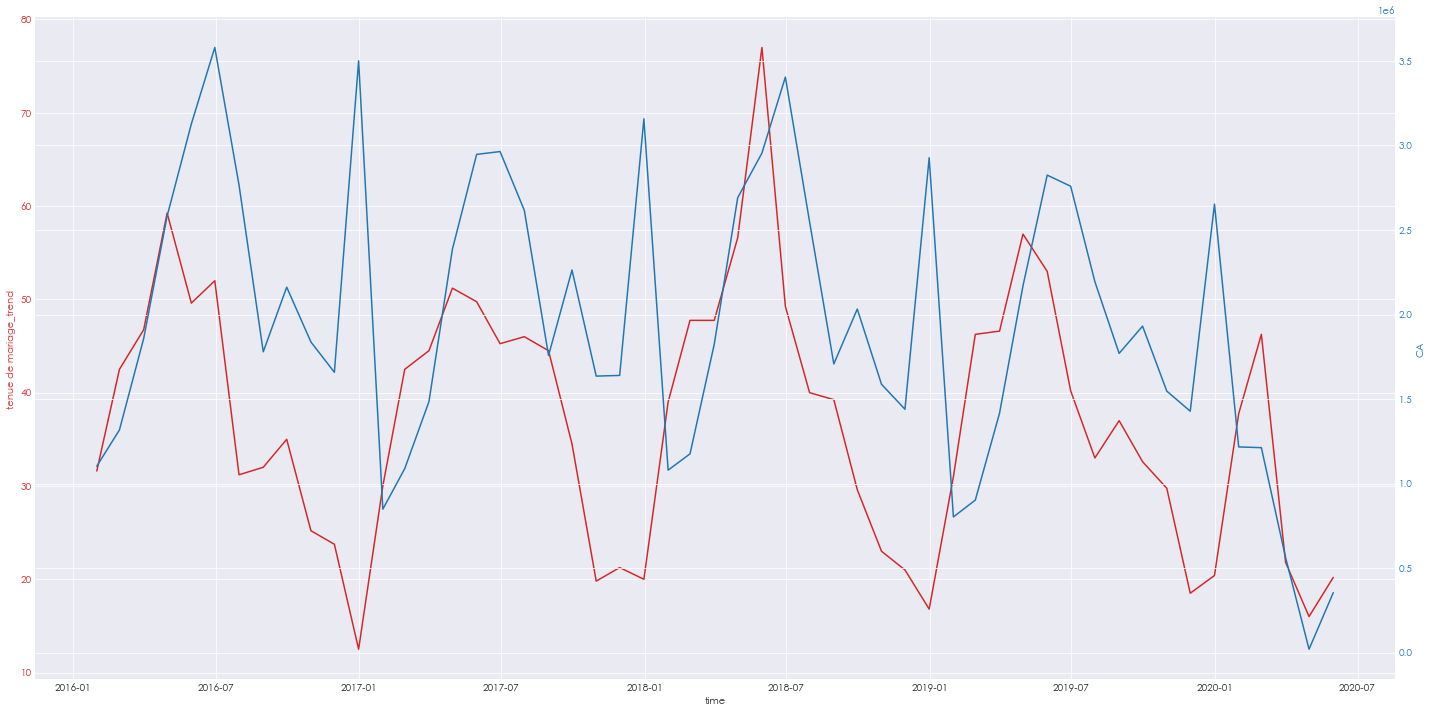

In [34]:
def plot_df(data_frame, column, lag = lag_shift):

    fig, ax1 = plt.subplots(figsize=(20,10))

    color = 'tab:red'
    ax1.set_xlabel('time')
    ax1.set_ylabel(trend_column, color=color)
    ax1.plot(data_frame[trend_column].shift(lag), color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel(column, color=color)  # we already handled the x-label with ax1
    ax2.plot(data_frame[column], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
plot_df(df,'CA', lag = 0 )

In [35]:
def df_shift(df = df, column = 'CA', lag = lag_shift, covid_truncate = False, one_year = False):
    df_shifted = df.copy()
    df_shifted[keyword+'_trend'] = df_shifted['tenue de mariage_trend'].shift(lag)
    if lag<0:
        df_shifted= df_shifted[0:lag]
    else:
        df_shifted= df_shifted[lag:]

    if covid_truncate:
        df_shifted = df_shifted[df_shifted.index<'2020-03']
    if one_year:
        df_shifted = df_shifted[df_shifted.index<'2020']
        df_shifted = df_shifted[df_shifted.index>='2019']


    return(df_shifted)

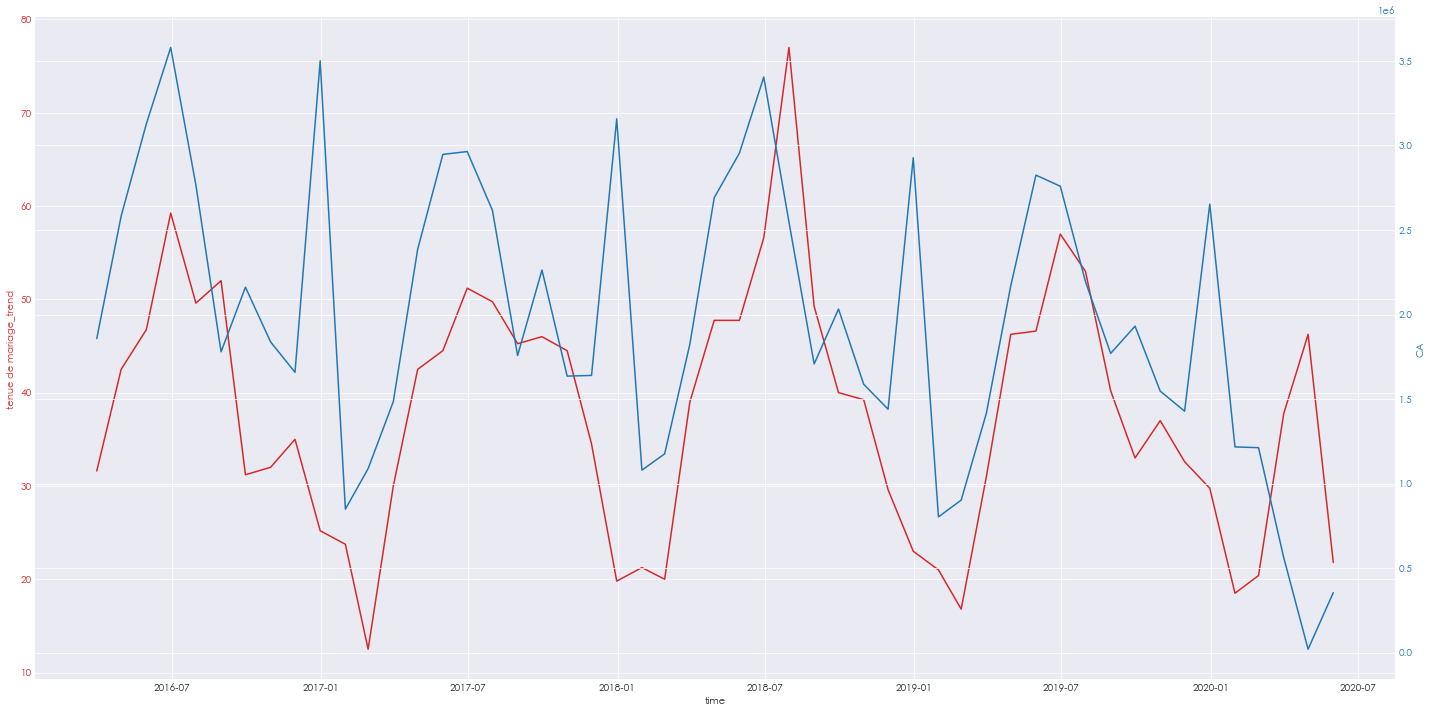

nb_sales                  0
CA                        0
tenue de mariage_trend    0
dtype: int64


In [36]:
df_lag=df_shift()
plot_df(df_lag,'CA', 0)
print(df.isnull().sum())

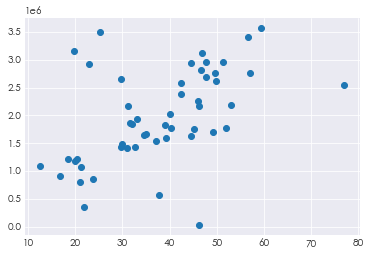

In [37]:
plt.scatter(df_lag['tenue de mariage_trend'], df_lag['CA'])


In [38]:

X = pd.DataFrame(df_lag[trend_column])
y = pd.DataFrame(df_lag['CA'])
model = LinearRegression()

model.fit(X, y)
model.score(X,y)

0.24568884012868863

In [39]:
scores = []
kfold = KFold(n_splits=2, shuffle=True, random_state=40)
for i, (train, test) in enumerate(kfold.split(X, y)):
    #print(len(X.iloc[train,:]))
    #print(len(X.iloc[test,:]))
    model.fit(X.iloc[train,:], y.iloc[train,:])
    score = model.score(X.iloc[test,:], y.iloc[test,:])
    scores.append(score)
print(scores)

[0.2771567577880002, 0.14554783336364185]


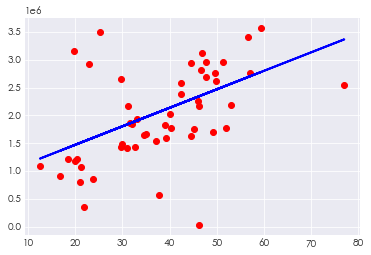

In [40]:
y_pred = model.predict(X)
plt.plot(X, y_pred, color='blue', linewidth=2)
plt.scatter(X, y, color = 'red')

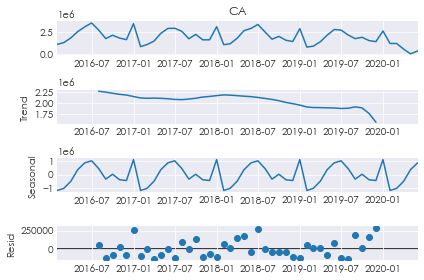

In [41]:
decompose_time_series(df['CA'])

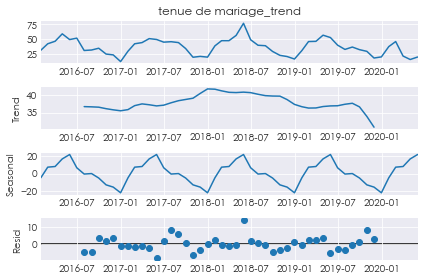

In [42]:
decompose_time_series(df[trend_column])

In [49]:


def grangers_causation_matrix(data, variables, test='ssr_chi2test', maxlag=3, verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """

    
    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_var' for var in variables]
    df.index = [var + '_pred' for var in variables]
    return df



In [50]:
#maxlag=12
#test = 'ssr_chi2test'

grangers_causation_matrix(df, variables = df.columns)


,nb_sales_var,CA_var,costume_trend_var
nb_sales_pred,1.0000,0.0003,0.0
CA_pred,0.0000,1.0000,0.0
costume_trend_pred,0.2989,0.3053,1.0


In [277]:
#df.drop(columns='nb_sales', inplace=True)

In [278]:
nobs = 6
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)  # (4, 8)

(47, 3)
(6, 3)


In [279]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

In [280]:
list_cost = df[trend_column]
list_sales = df['CA']

rs = [crosscorr(list_cost,list_sales, lag) for lag in range(-12,12)]
print('Lag max Correlation (',interpolate_mode,'):', np.argmax(rs), '\n')
print( 'Correlation :', rs[np.argmax(rs)])

#print(crosscorr(list_cost,list_sales, 10))

#offset = np.ceil(len(rs)/2)-np.argmax(rs)
#f,ax=plt.subplots(figsize=(20,10))
#ax.plot(rs)
#ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
#ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
#ax.set(title=f'Offset = {offset} frames\nS1 leads <> S2 leads',ylim=[-.1,.5],xlim=[0,301], xlabel='Offset',ylabel='Pearson r')
#ax.set_xticks([0, 50, 100, 151, 201, 251, 301])
#ax.set_xticklabels([-150, -100, -50, 0, 50, 100, 150]);
#plt.legend()

Lag max Correlation ( M ): 10 

Correlation : 0.5603153074043984


In [284]:


def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='t-stat', maxlag=12)
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [285]:

for name, column in df_train.iteritems():
    print(len(column))
    adfuller_test(column, name=column.name)
    print('\n')

47
    Augmented Dickey-Fuller Test on "nb_sales" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 0.0274
 No. Lags Chosen       = 11
 Critical value 1%     = -3.633
 Critical value 5%     = -2.949
 Critical value 10%    = -2.613
 => P-Value = 0.9607. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


47
    Augmented Dickey-Fuller Test on "CA" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.2747
 No. Lags Chosen       = 12
 Critical value 1%     = -3.639
 Critical value 5%     = -2.951
 Critical value 10%    = -2.614
 => P-Value = 0.929. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


47
    Augmented Dickey-Fuller Test on "costume_trend" 
    -----------------------------------------------
 Null Hypothes

In [287]:
df_differenced = df_train.diff().dropna()
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "nb_sales" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.7058
 No. Lags Chosen       = 12
 Critical value 1%     = -3.646
 Critical value 5%     = -2.954
 Critical value 10%    = -2.616
 => P-Value = 0.4282. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "CA" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.5644
 No. Lags Chosen       = 12
 Critical value 1%     = -3.646
 Critical value 5%     = -2.954
 Critical value 10%    = -2.616
 => P-Value = 0.5014. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "costume_trend" 
    -----------------------------------------------
 Null Hypothesis: Dat

In [288]:
df_differenced = df_differenced.diff().dropna()
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "nb_sales" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.7217
 No. Lags Chosen       = 11
 Critical value 1%     = -3.646
 Critical value 5%     = -2.954
 Critical value 10%    = -2.616
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "CA" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.7989
 No. Lags Chosen       = 11
 Critical value 1%     = -3.646
 Critical value 5%     = -2.954
 Critical value 10%    = -2.616
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "costume_trend" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Lev

In [294]:
model = VAR(df_differenced)
x = model.select_order(maxlags=10)
x.summary()


,AIC,BIC,FPE,HQIC
0,54.08,54.21,3.054e+23,54.12
1,52.90,53.44,9.489e+22,53.09
2,51.84,52.77,3.306e+22,52.16
3,50.72,52.05,1.116e+22,51.18
4,49.21,50.94,2.636e+21,49.81
5,48.52,50.65,1.468e+21,49.26
6,48.01,50.54,1.048e+21,48.88
7,47.50,50.44,8.276e+20,48.51
8,44.41,47.74,5.764e+19,45.56
9,42.07,45.80,1.116e+19,43.36


In [296]:
model_fitted = model.fit(10)
#model_fitted.summary()


In [297]:
from statsmodels.stats.stattools import durbin_watson


out = durbin_watson(model_fitted.resid)


for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))

nb_sales : 1.85
CA : 2.35
costume_trend : 1.27


In [298]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_train.values[-lag_order:]
forecast_input

10


array([[3.28420000e+04, 9.02313030e+05, 6.40000000e+01],
       [4.07310000e+04, 1.41611674e+06, 6.84000000e+01],
       [5.85090000e+04, 2.16931892e+06, 6.15000000e+01],
       [7.56060000e+04, 2.82446246e+06, 6.42500000e+01],
       [8.36290000e+04, 2.75873000e+06, 5.88000000e+01],
       [7.69760000e+04, 2.19411957e+06, 4.75000000e+01],
       [5.01110000e+04, 1.77009938e+06, 4.95000000e+01],
       [5.20480000e+04, 1.93111473e+06, 5.86000000e+01],
       [4.20030000e+04, 1.54686714e+06, 8.65000000e+01],
       [5.05320000e+04, 1.42812730e+06, 5.82500000e+01]])

In [299]:
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast

,nb_sales_2d,CA_2d,costume_trend_2d
sale_date,,,
2019-12-31,-2.798157e+06,-6.196212e+07,-431.503327
2020-01-31,3.088728e+06,6.311828e+07,1420.201426
2020-02-29,-1.308701e+06,-2.262956e+07,-293.021427
2020-03-31,9.824080e+05,4.294636e+07,-151.118704
2020-04-30,-2.284600e+06,-5.162020e+07,-481.044179
2020-05-31,1.496078e+06,3.255828e+07,-280.916326


In [304]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    print(0)
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
            

        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    print(0)
    return df_fc

In [305]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True)        
df_results.loc[:, ['costume_trend_forecast', 'CA_forecast', 'nb_sales_forecast']]


0
0


,costume_trend_forecast,CA_forecast,nb_sales_forecast
sale_date,,,
2019-12-31,-401.503327,-6.065274e+07,-2.739096e+06
2020-01-31,558.944772,-5.961532e+07,-2.439996e+06
2020-02-29,1226.371444,-8.120747e+07,-3.449596e+06
2020-03-31,1742.679413,-5.985325e+07,-3.476789e+06
2020-04-30,1777.943202,-9.011923e+07,-5.788581e+06
2020-05-31,1532.290665,-8.782693e+07,-6.604296e+06


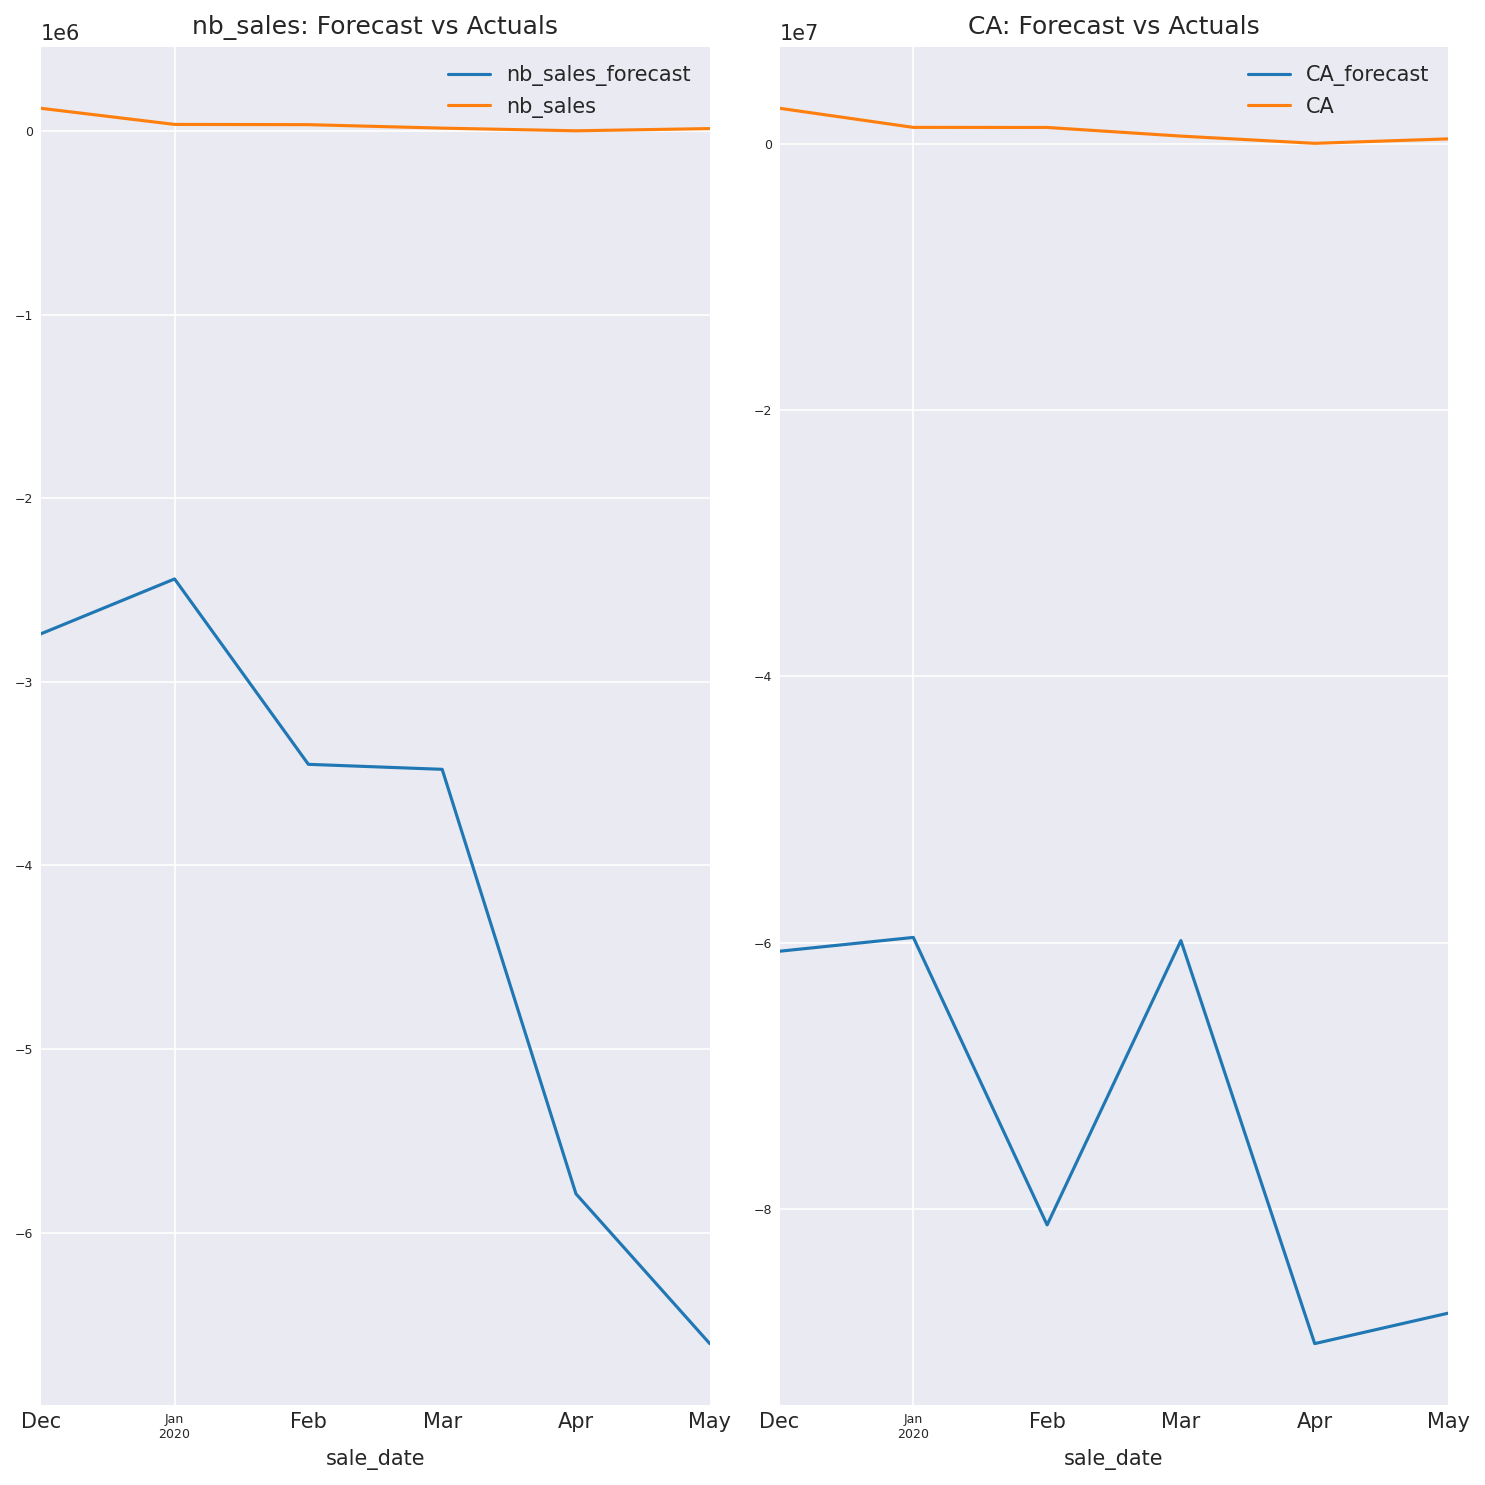

In [306]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();
